In [ ]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import ta

#from preprocesslib import preprocessEach, makeY

In [ ]:
import os
import pandas as pd
import numpy as np

'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''
def preprocessEach(folder_name):
   # set file path
    # folder_path = f'/content/drive/MyDrive/research/data/{folder_name}_clean'
    folder_path = f'../data/{folder_name}_clean'


    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path, index_col=0)
        df.index = pd.to_datetime(df.index)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df['RSI'] = ta.momentum.rsi(df['Close'])
        df['MACD'] = ta.trend.macd(df['Close'])


        df = df[['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']]
        df.fillna(0,inplace=True)



        #log transform
        df = np.log1p(df)
        # df.reset_index(inplace=True)
        df.fillna(0,inplace=True)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)
def makeY(folder_name, filelength):

    if folder_name=='growth':
        yGrowths = np.ones(filelength)
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yGrowths = np.zeros(filelength)
        yValues = np.ones(filelength)
    elif folder_name=='overlap':
        yGrowths = np.ones(filelength)
        yValues = np.ones(filelength)

    y = np.column_stack([yGrowths.T, yValues.T])
    return y

In [ ]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

In [ ]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [ ]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
yOverlaps = makeY('overlap', n_samples)

In [ ]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [ ]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(8):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    np.random.seed(2023)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [ ]:
#model
def makeModel(unit, dropout):
  model = Sequential()
  model.add(LSTM(unit, input_shape=(1248,8), return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(2, activation='sigmoid'))
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
  mc = ModelCheckpoint('base_model.h5', monitor='val_acc', mode='max', save_best_only=True)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model, es, mc

In [ ]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [ ]:
def cvsplitData(x,y, ind):
  x_test = x[ind]
  y_test = y[ind]
  cnt = 0
  for i in range(len(x)):
    if i!=ind:
      if cnt == 0:
        x_train = x[i]
        y_train = y[i]
        cnt += 1
      else:
        x_train = np.concatenate((x_train, x[i]))
        y_train = np.concatenate((y_train, y[i]))
  return x_train, x_test, y_train, y_test
  

In [ ]:
#cross validation
X_train, X_test, Y_train, Y_test = splitData(x,y)
x_train, x_test, y_train, y_test = splitData(x,y)

x_split, y_split = splitDataCrossVal(X_train, Y_train)
# f = open('/content/drive/MyDrive/research/models/performance.txt', 'a')
batchs = [64]
units = [64]
dropouts = [0.2]
epochs = [1000]
for batch in batchs:
  for epoch in epochs:
    for unit in units:
      for dropout in dropouts:
        accuracy_cross_val = []
        # for i in range(len(x_split)):
        x_train = pad_sequences(x_train, dtype='float32')
        x_test = pad_sequences(x_test, dtype='float32')
        x_train = np.nan_to_num(x_train, nan=0)
        x_test = np.nan_to_num(x_test, nan=0)
        model,es,mc = makeModel(unit, dropout)
        history=model.fit(x_train, y_train, epochs=epoch, batch_size=batch, validation_split=0.2, callbacks=[es, mc])
        # model=load_model('base_model.h5')
        # loss, accuracy = model.evaluate(x_test, y_test)
        # # accuracy_cross_val.append(accuracy)
        # print("batch : {}, unit: {}, dropout:{} accuracy:{}".format(batch, unit, dropout, ))
        # f.write("batch : {}, unit: {}, dropout:{} accuracy:{}\n".format(batch, unit, dropout, sum(accuracy_cross_val)/len(accuracy_cross_val)))

In [41]:
model=load_model('base_model.h5')
Y_pred = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, Y_test)
print("accuracy:{}".format(accuracy))

21/21 [==============================] - 1s 27ms/step - loss: 0.6389 - acc: 0.6796
accuracy:0.6796267628669739


In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18688     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 18,818
Trainable params: 18,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.figure(figsize=(14,6))
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.figure(figsize=(14,6))
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
y_pred=[]
for sample in  Y_pred:
  y_pred.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred = np.array(y_pred)
y_pred

array([[1, 1],
       [1, 0],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 0]])

In [64]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test, y_pred)

array([[[  1, 226],
        [  0, 416]],

       [[115,  94],
        [134, 300]]])

In [65]:
from sklearn.metrics import classification_report
label_names = ['Growth', 'Value']
print(classification_report(Y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

      Growth       0.65      1.00      0.79       416
       Value       0.76      0.69      0.72       434

   micro avg       0.69      0.84      0.76       850
   macro avg       0.70      0.85      0.76       850
weighted avg       0.71      0.84      0.75       850
 samples avg       0.71      0.86      0.74       850



In [67]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred))
print(accuracy_score(Y_test[:,0], y_pred[:,0]))
print(accuracy_score(Y_test[:,1], y_pred[:,1]))



0.37325038880248834
0.6485225505443235
0.645412130637636


In [61]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.69


In [56]:
import matplotlib.pyplot as plt
def y_bin(selectedLabel,Y_test,Y_pred_per ):
    y_binary = Y_test[:,selectedLabel]
    y_binary_scores = Y_pred_per[:,selectedLabel]
    return y_binary, y_binary_scores
def plt_roc_curve(fpr, tpr, selectedVal):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve' )
    plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(label_names[selectedVal]))
    plt.legend(loc="lower right")
    plt.show()

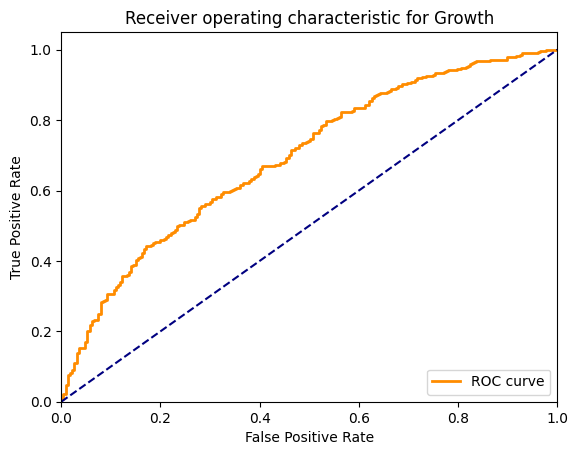

0.5022026431718062

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
growth_val = 0
growth_y_bin, growth_y_bin_per = y_bin(growth_val, Y_test, Y_pred)

g_fpr, g_tpr, g_thresholds = roc_curve(growth_y_bin, growth_y_bin_per)
plt_roc_curve(g_fpr, g_tpr, growth_val)
roc_auc_score(Y_test[:,growth_val], y_pred[:,growth_val])


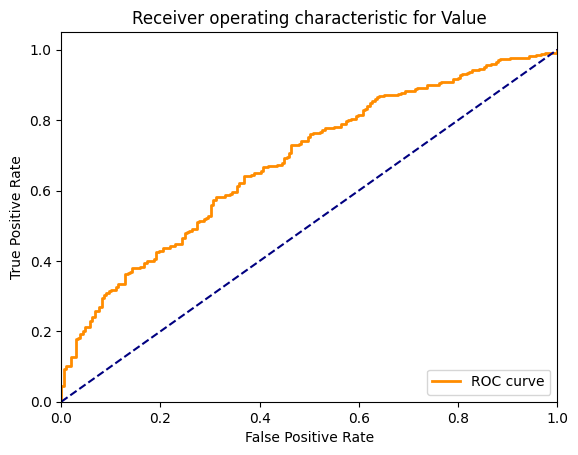

0.6824135117853285

In [58]:
value_val = 1
value_y_bin, value_y_bin_per = y_bin(value_val, Y_test, Y_pred)
v_fpr, v_tpr, v_thresholds = roc_curve(value_y_bin, value_y_bin_per)
plt_roc_curve(v_fpr, v_tpr, value_val)
roc_auc_score(Y_test[:,value_val], Y_pred[:,value_val])
